YouTube per-CPU TGID residency analysis
=======================
This is a run of experiments/run_youtube.py with the cgroups module enabled.
This notebook parses and plots the trace.html

In [6]:
#!/usr/bin/env python
%pylab inline
import trappy
from trace import Trace
import itertools
import logging
import pandas as pd
import numpy as np
import os

from conf import LisaLogging
LisaLogging.setup()
logging.info('#### Setup FTrace')
# path_to_html = "/home/joelaf/repo/lisa-aosp/external/lisa/results/UiBench_default/trace.html"
# path_to_html = "/home/joelaf/repo/lisa-aosp/external/lisa/ipynb/residency/trace-residency.html"
path_to_html = "/home/joelaf/repo/lisa-aosp/external/lisa/results/YouTube_cgroups/trace.html"

2017-07-15 01:23:58,298 INFO    : root         : Using LISA logging configuration:
2017-07-15 01:23:58,301 INFO    : root         :   /home/joelaf/repo/lisa-aosp/external/lisa/logging.conf
2017-07-15 01:23:58,303 INFO    : root         : #### Setup FTrace


In [24]:
def plot_cgroups(df):
    # Bug in matplot lib causes plotting issues when residency is < 1
    df = df.apply(lambda x: x*10)
    plt.style.use('ggplot')
    colors = plt.rcParams['axes.color_cycle']
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,30))

    for ax, col in zip(axes.flat, df.columns):
        ax.pie(df[col], labels=df.index, autopct='%.2f', colors=colors)
        ax.set(ylabel='', title=col, aspect='equal')

    axes[0, 0].legend(bbox_to_anchor=(0, 0.5))

    # fig.savefig('your_file.png') # Or whichever format you'd like
    plt.show()

tr = Trace(None, path_to_html,
           cgroup_info = { 
               'cgroups': ['foreground', 'background', 'system-background', 'top-app', 'rt'],
               'controller_ids': { 4: 'cpuset', 2: 'schedtune' }
           },
           events=[ 'sched_switch', 'cgroup_attach_task_devlib', 'cgroup_attach_task', 'sched_process_fork' ],
        normalize_time=False)

Total amount of time spent per TGID
===========================

In [25]:
cdf = tr.data_frame.cpu_residencies('tgid_comm', event_name='sched_switch_cgroup')
# Due to the noise in the pie plots due to large number of TGIDs, drop any that
# don't meet the bar (run on CPUs for a total of atleast 0.7s)
cdf = cdf[~(cdf < 0.7).all(1)]
cdf

2017-07-15 01:44:22,594 INFO    : root         : TOTAL number of CPUs: 8
2017-07-15 01:44:22,595 INFO    : root         : TOTAL number of PIDs: 951
2017-07-15 01:44:22,596 INFO    : root         : TOTAL number of TGIDs: 950
2017-07-15 01:44:37,907 INFO    : root         : Generating residency for 185 tgid_comms!
2017-07-15 01:44:37,912 INFO    : root         : total time spent by all pids across all cpus: 259.21056
2017-07-15 01:44:37,913 INFO    : root         : total real time range of events: 32.083223


,cpu_0,cpu_1,cpu_2,cpu_3,cpu_4,cpu_5,cpu_6,cpu_7,total
tgid_comm,,,,,,,,,
.gms.persistent,0.126132,0.093887,0.129987,0.114014,0.000000,0.000000,0.282906,0.346375,1.093301
android.youtube,0.378246,0.195657,0.111728,0.085123,3.883613,2.620660,1.138236,0.341751,8.755014
audioserver,0.324777,0.539268,0.179528,0.138533,0.000000,0.000000,0.034319,0.012857,1.229282
composer@2.1-se,0.637039,1.714824,0.122500,0.064408,0.000860,0.000000,0.002368,0.003812,2.545811
mdss_fb0,0.000000,0.000000,0.488047,0.917949,0.000000,0.000000,0.000000,0.000000,1.405996
sh,0.123595,0.017595,0.023969,0.117765,0.184260,0.135337,0.054405,0.174685,0.831611
surfaceflinger,2.122230,1.033651,0.383079,0.127894,0.379442,0.077457,0.030958,0.010078,4.164789
system_server,0.445757,0.499595,0.493926,0.267354,0.010206,0.001380,0.409837,1.059832,3.187887
NaN,24.169153,26.310930,28.413301,29.423310,27.095635,28.958375,29.406846,29.596954,223.374504


Plot per-CPU breakdown without considering idle time
------------------------------------------------------------

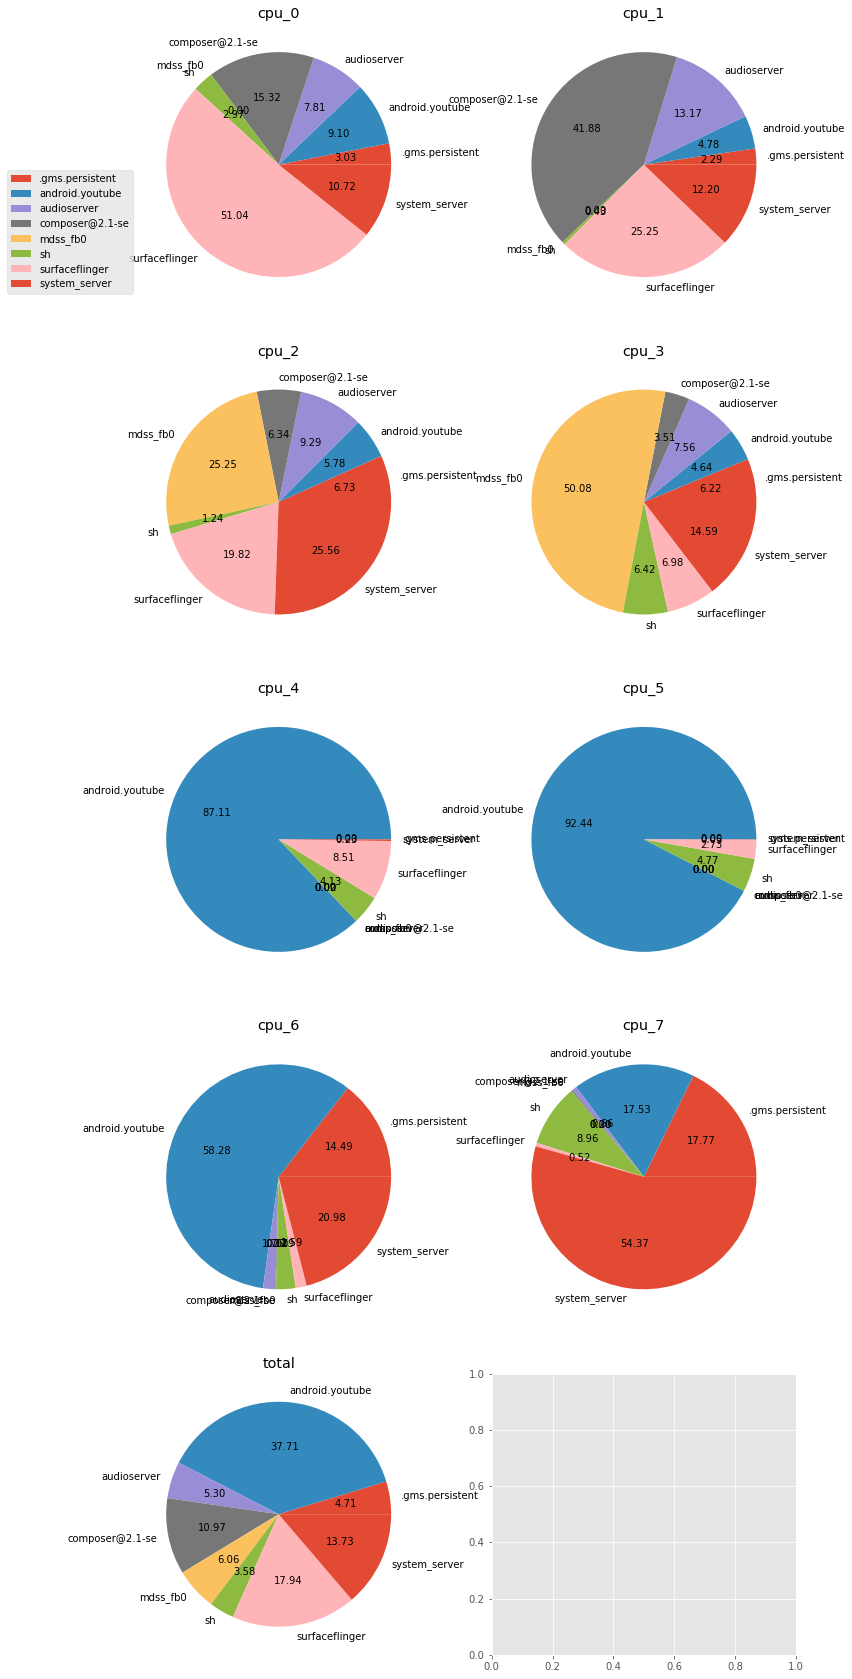

In [26]:

# Drop NaN
ncdf = cdf[pd.isnull(cdf.index) != True]
plot_cgroups(ncdf)

Plot per-CPU breakdown WITH considering idle time (yellow slice)
------------------------------------------------------------

Populating the interactive namespace from numpy and matplotlib


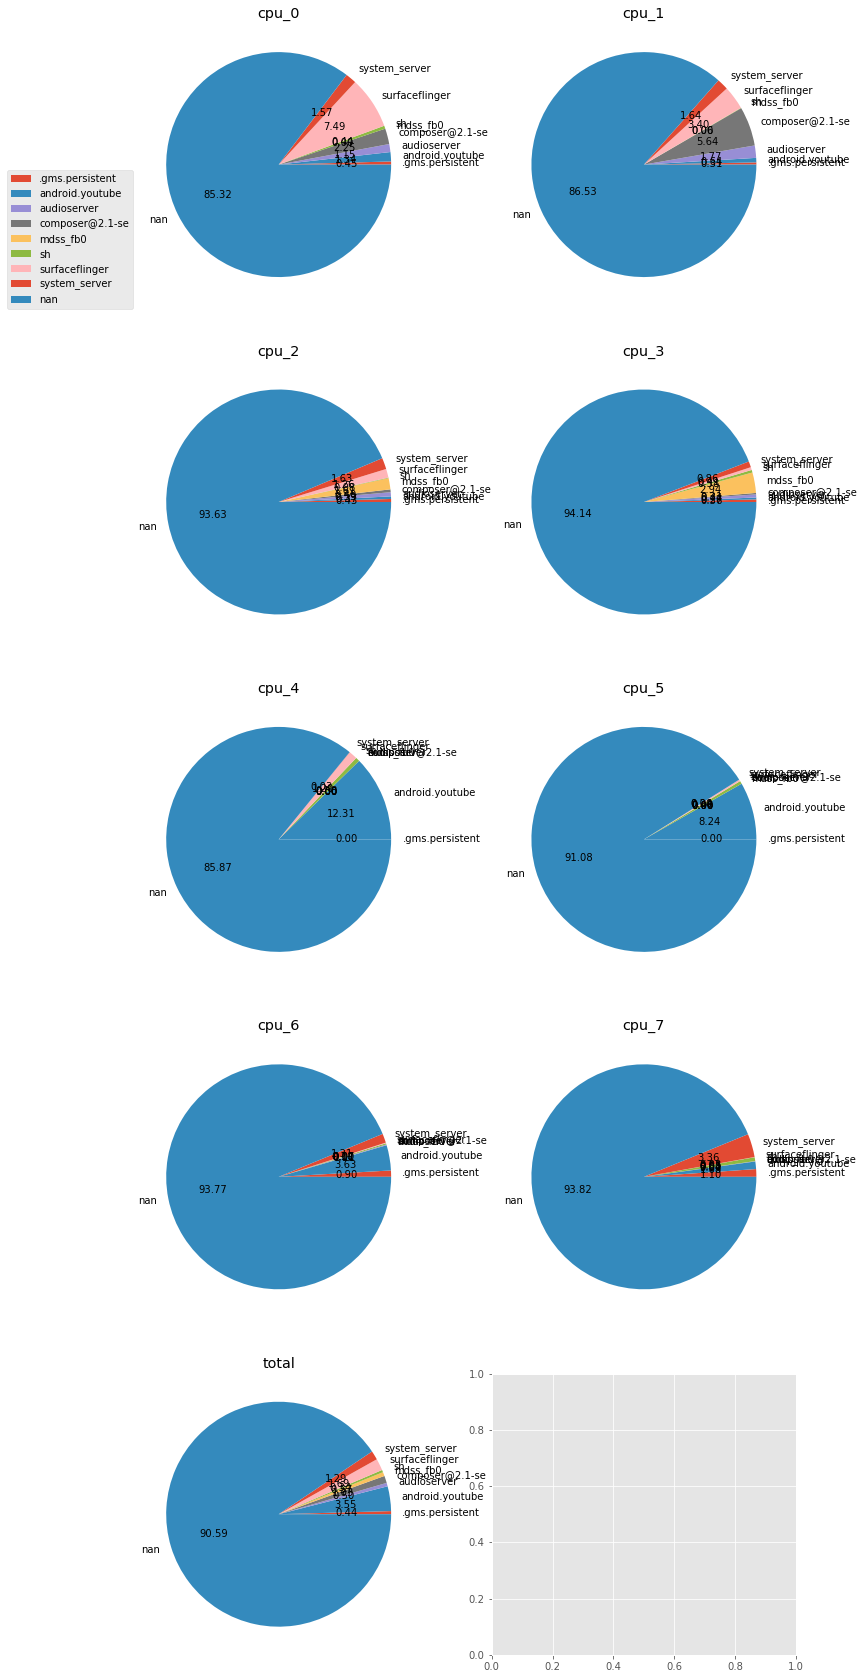

In [27]:
%pylab inline
plot_cgroups(cdf)